In [1]:
import xarray as xr
import numpy as np
import dask
from tqdm import tqdm
import pandas as pd
import xwmb
import xwmt
import xgcm
import warnings
warnings.filterwarnings('ignore')
import math

import numpy as np
import regionate
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import cftime
from datetime import datetime

In [2]:
xwmb.__version__, xwmt.__version__, xgcm.__version__

('0.1.0', '0.1.1', '0.8.2.dev15+g7492277')

In [3]:
hfdrake_path = "/pub/hfdrake/datasets/CM4_MHW_blobs/data_daily/"
ds = xr.open_mfdataset(f"{hfdrake_path}/*.ocean_daily.*.nc", chunks={"time":1})
snap = xr.open_mfdataset(f"{hfdrake_path}/*.ocean_daily_snap*.nc", chunks={"time":1})
static = xr.open_dataset("/pub/hfdrake/datasets/CM4_MHW_blobs/data/WMT_monthly/ocean_month_rho2.static.nc")

mt_path = "/pub/mariant3/WarmWaterMasses/notebooks/02_mhw_metrics/data_ocetrac-labels/"
blobs = xr.open_dataset(f"{mt_path}/01860503-01901020_ocetrac-labels-region.nc")
labels = blobs.blobs.rename('event_mask')
df = pd.read_pickle(f"{mt_path}/01860503-01901020_mhw-metrics-region.pkl")
wmt = xr.open_dataset("/pub/mariant3/WarmWaterMasses/notebooks/04_WMT-MHW/WMT_data/0186-0189_wmt-daily.nc")

In [144]:
#event_label = 25
df.loc[df.id==25].date.values[-1][0]

numpy.datetime64('0186-07-26')

In [4]:
budgets = xr.open_dataset("/pub/mariant3/WarmWaterMasses/notebooks/04_WMT-MHW/WMT_data/mhw_wmt-budgets_anomaly_0186-0189.nc")

In [5]:
budgets_sum = budgets.sum('mhw')

NameError: name 'labels' is not defined

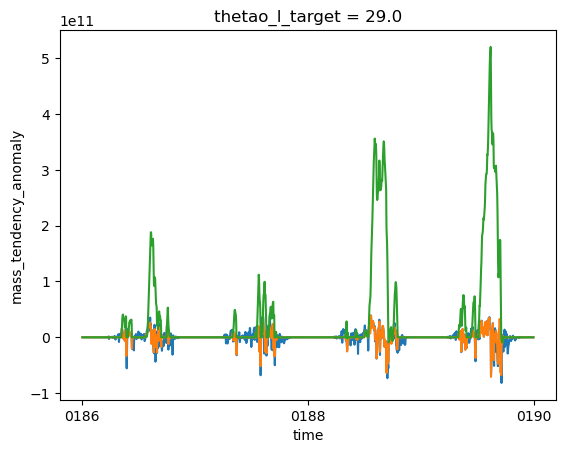

In [6]:
wmt.mass_tendency.sel(thetao_l_target=29, method='nearest').plot()
budgets_sum.mass_tendency.sel(thetao_l_target=29, method='nearest').plot()
budgets_sum.mass_tendency_anomaly.sel(thetao_l_target=29, method='nearest').plot()

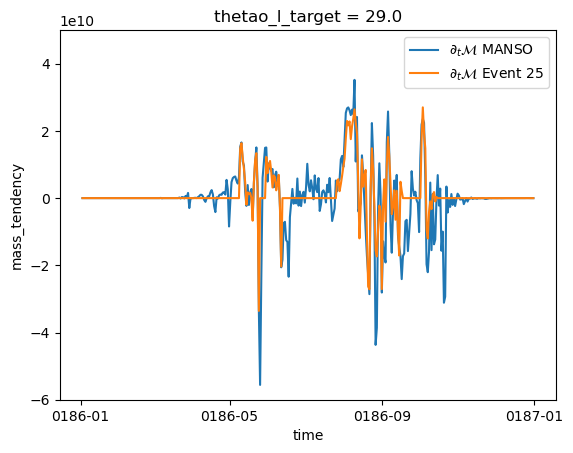

In [15]:
wmt.mass_tendency.sel(time=slice('0186','0186')).sel(thetao_l_target=29,method="nearest").plot(label=r"$\partial_{t} \mathcal{M}$ MANSO")
budgets_sum.mass_tendency.sel(time=slice('0186','0186')).sel(thetao_l_target=29,method="nearest").plot(label=r"$\partial_{t} \mathcal{M}$ Event 25")
#budgets_sum.mass_tendency_anomaly.sel(time=slice('0186','0186')).sel(thetao_l_target=29,method="nearest").plot(label=r"$\partial_{t} \mathcal{M}$ Event 25")

plt.ylim(-6e+10, 5e+10)
plt.legend()
plt.show()

In [26]:
budgets_sum.time[0].values

array(cftime.DatetimeNoLeap(186, 1, 2, 12, 0, 0, 0, has_year_zero=True),
      dtype=object)

In [212]:
import matplotlib.pyplot as plt
import numpy as np
import cftime


def plot_wmt(wmt, thetao, time_slice=None, label='manso', figsize=(10, 3), vmin=None, vmax=None, xlim=None, ylim=None,save_path=None):
    """
    Plotting calculated wmt for a given region

    Parameters:
    - wmt
    - thetao: target temperature
    - time_slice: Optional. Write as ('start_date', 'end_date').
      If None, the entire time range will be plotted.
    - label (str): Optional. The label for the plot.
    - figsize (tuple): Optional. Size of the figure (width, height).
    - vmin (float): Optional. Minimum value for color scale.
    - vmax (float): Optional. Maximum value for color scale.

    Returns:
    None
    """
    fontsize=16
    wmt_sel = wmt.sel(thetao_l_target=thetao, method='nearest')
    
    if time_slice:
        wmt_sel = wmt_sel.sel(time=slice(time_slice[0], time_slice[1]))

    plt.figure(figsize=figsize)  
    
    (-wmt_sel.boundary_fluxes).plot(label=r"$\langle \mathcal{-G}^{(BF)} \rangle$")#, color="C1")
    wmt_sel.mass_tendency.plot(label=r"$\partial_{t} \mathcal{M}$")#,color='k')
    (-wmt_sel.diffusion).plot(label=r"$\langle \mathcal{-G}^{(Mix)} \rangle$")#, color="C0")#\mathcal{G}^{mix}
    wmt_sel.mass_source.plot(label=r"$\langle \mathcal{S} \rangle$")#, color="C2")
    wmt_sel.convergent_mass_transport.plot(label=r"$-\langle \Psi\rangle$")
    (-wmt_sel.spurious_numerical_mixing).plot(label=r"$\langle \mathcal{-G}^{(S)} \rangle$")#, color="C4")

    plt.xlim(wmt_sel.time[0].values,wmt_sel.time[-1].values)
    plt.ylim(-8.7e+10, 5.9e+10)
    plt.legend(loc=3,frameon=False,bbox_to_anchor=(1, 0.3), fontsize=fontsize)
    plt.title(label,fontsize=18)
    plt.grid(True, linewidth=0.1)
    #plt.ylabel(r"Cumulative WMT",fontsize=18)
    plt.ylabel("")
    plt.xlabel("")

    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    
    if vmin is not None and vmax is not None:
        plt.ylim(vmin, vmax)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
    plt.show()


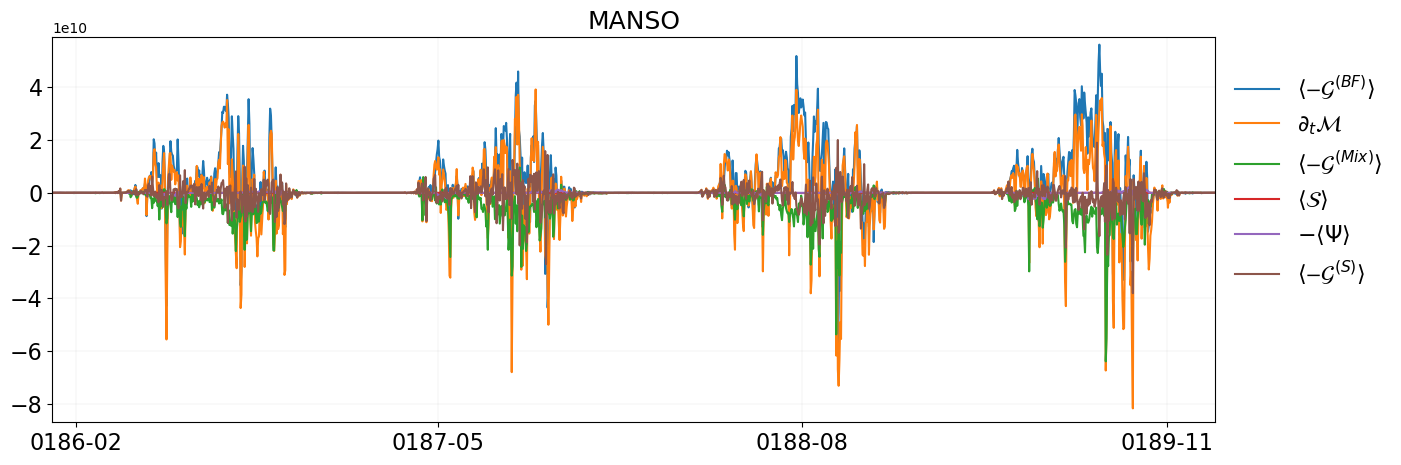

In [219]:
plot_wmt(wmt, thetao=29, label='MANSO',time_slice=('0186','0190'),figsize=(15, 5),save_path=f'/pub/mariant3/WarmWaterMasses/figures/mass_budget/dmdt-budget-manso-all-years-talk.png')
#plt.savefig(f'/pub/mariant3/WarmWaterMasses/figures/mass_budget/dmdt-budget-manso-talk.png', dpi=300, bbox_inches='tight')

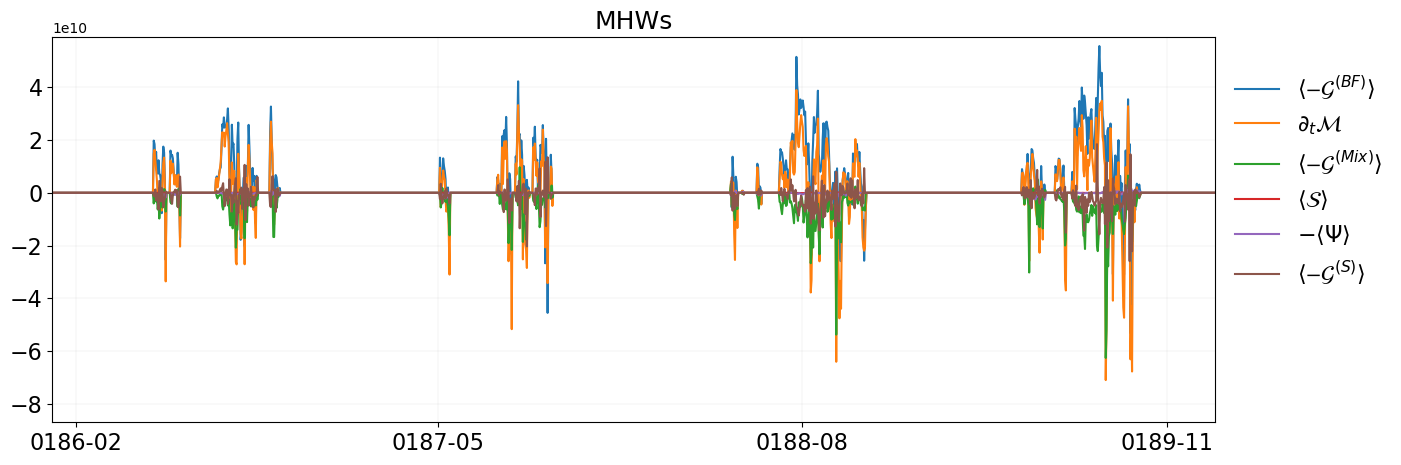

In [220]:
plot_wmt(budgets_sum, thetao=29, label='MHWs',time_slice=('0186','0190'),figsize=(15, 5),save_path=f'/pub/mariant3/WarmWaterMasses/figures/mass_budget/dmdt-budget-mhws-all-years-talk.png')

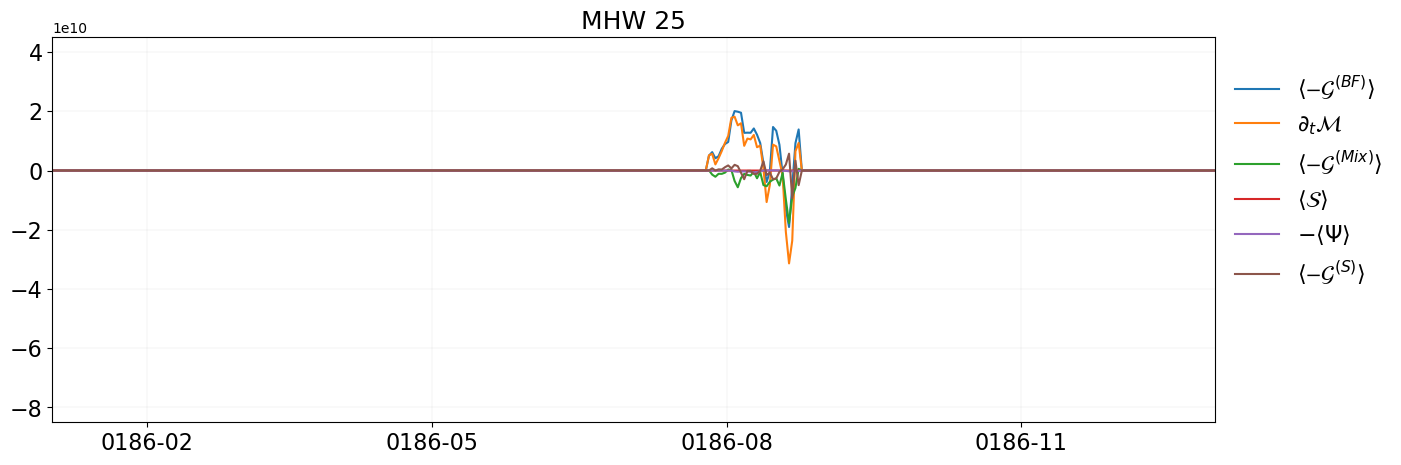

In [194]:
plot_wmt(budgets.sel(mhw=25,method='nearest'), thetao=29, label='MHW 25',time_slice=('0186','0186'),figsize=(15, 5),save_path=f'/pub/mariant3/WarmWaterMasses/figures/mass_budget/dmdt-budget-mhw25-talk.png')
#plt.savefig(f'/pub/mariant3/WarmWaterMasses/figures/mass_budget/dmdt-budget-mhw25-talk.png', dpi=300, bbox_inches='tight')

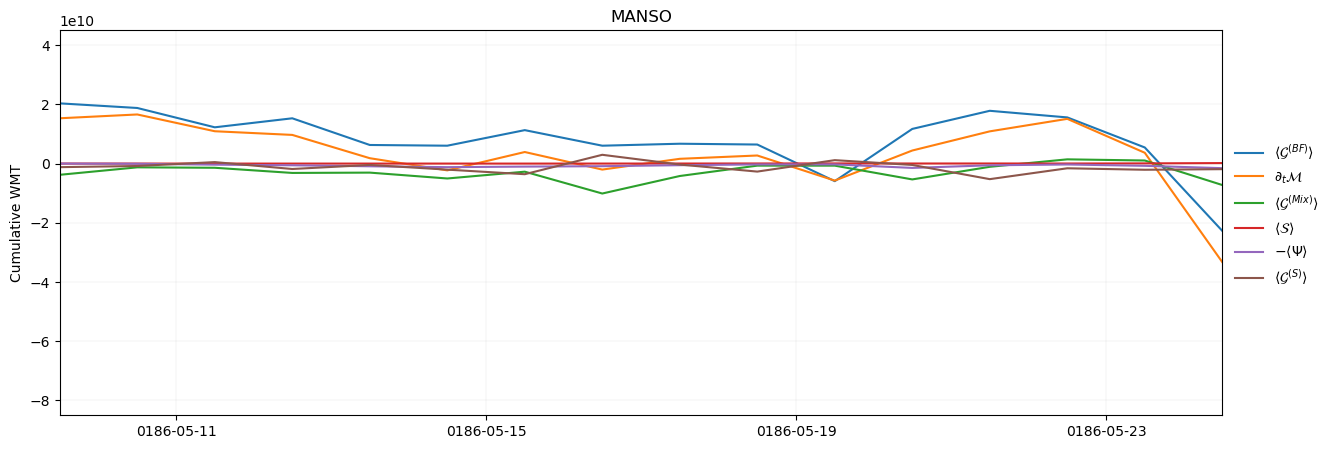

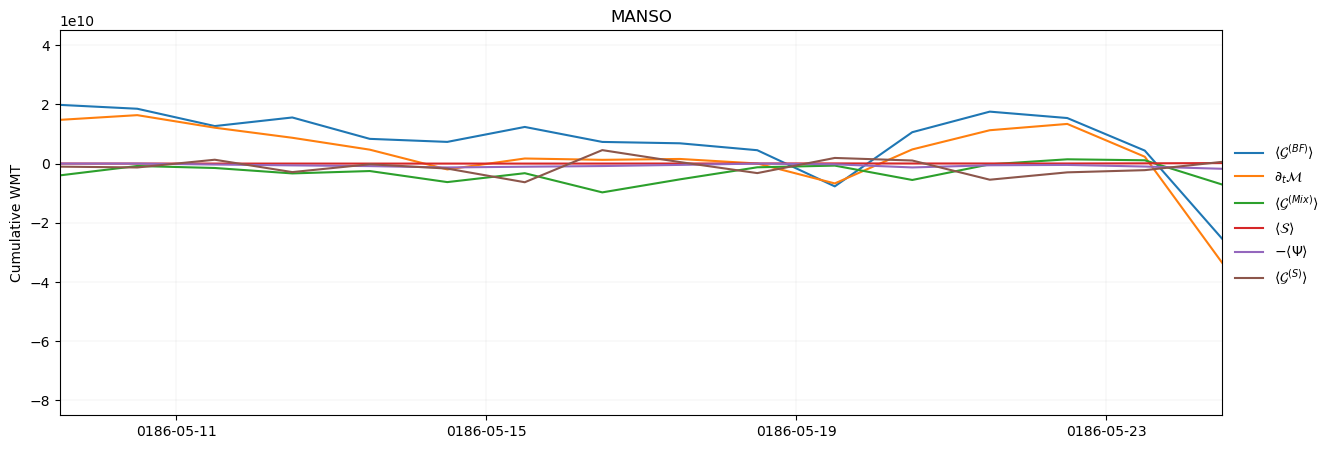

In [149]:
mhw_event= 3

plot_wmt(
    wmt,
    thetao=29,
    label='MANSO',
    time_slice=(
        f"{df.loc[df.id==mhw_event].date.values[-1][0]}",
        f"{df.loc[df.id==mhw_event].date.values[-1][-1]}"
    ),
    figsize=(15, 5)
)


plot_wmt(
    budgets.sel(mhw=mhw_event,method='nearest'),
    thetao=29,
    label='MANSO',
    time_slice=(
        f"{df.loc[df.id==mhw_event].date.values[-1][0]}",
        f"{df.loc[df.id==mhw_event].date.values[-1][-1]}"
    ),
    figsize=(15, 5)
)
#plot_wmt(budgets.sel(mhw=25,method='nearest'), thetao=29, label='MANSO',time_slice=('0186','0186'),figsize=(15, 5))

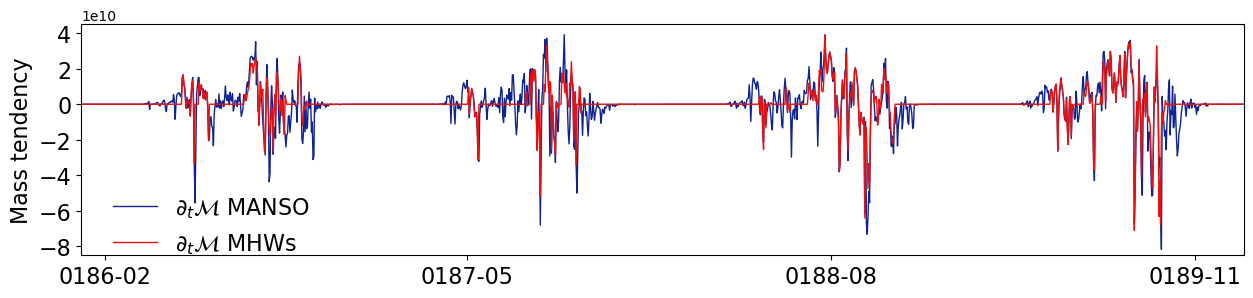

In [254]:
plt.figure(figsize=(15, 3))
wmt.mass_tendency.sel(thetao_l_target=29,method="nearest").plot(label=r"$\partial_{t} \mathcal{M}$ MANSO",color='#0f2491',linewidth=1)#'C7'
budgets_sum.mass_tendency.sel(thetao_l_target=29,method="nearest").plot(label=r"$\partial_{t} \mathcal{M}$ MHWs",color='#ed0e0e',linewidth=1)#'C3'
#budgets_sum.mass_tendency_anomaly.sel(time=slice('0186','0186')).sel(thetao_l_target=29,method="nearest").plot(label=r"$\partial_{t} \mathcal{M}$ Event 25")

plt.ylim(-8.5e+10, 4.5e+10)
plt.xlim(budgets_sum.time[0].values,budgets_sum.time[-1].values)
plt.legend(loc=3,frameon=False,fontsize=16,bbox_to_anchor=(0.01,-0.09))
plt.ylabel(r"Mass tendency",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("")
plt.title("")
#plt.savefig(f'/pub/mariant3/WarmWaterMasses/figures/mass_budget/dmdt-only-budget-manso-vs-mhws-all-years-talk.png', dpi=300, bbox_inches='tight')
plt.show()



In [ ]:
color='#0f2491'

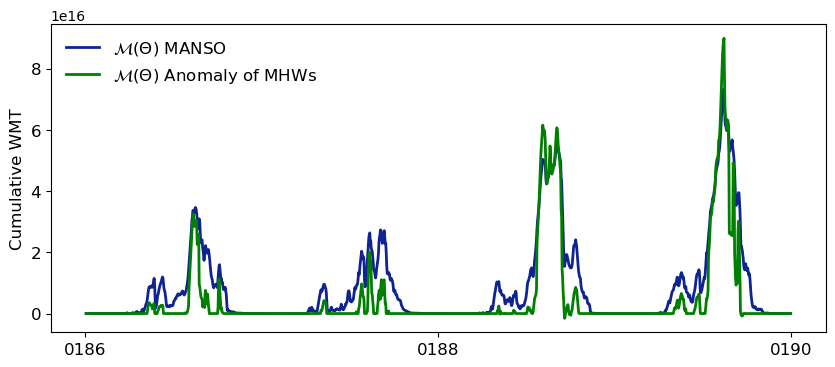

In [303]:
plt.figure(figsize=(10, 4))
ΔMManso = (wmt['mass_tendency']*wmt.dt).cumsum('time').sel(thetao_l_target=29, method='nearest')#.sel(time=slice('0187','0187'))
ΔMManso.plot(label=r"$ \mathcal{M}(\Theta)$ MANSO",color='#0f2491',linewidth=2)
ΔMMHW = (budgets_sum['mass_tendency']*budgets_sum.dt).cumsum('time').sel(thetao_l_target=29, method='nearest')#.sel(time=slice('0187','0187'))
#ΔMMHW.plot(label=r"$ \mathcal{M}(\Theta)$ MHWs",color='#ed0e0e',linewidth=2)
ΔMMHW_anomaly = (budgets_sum.mass_tendency_anomaly*budgets_sum.dt).sel(thetao_l_target=29, method='nearest')#.sel(time=slice('0187','0187'))
ΔMMHW_anomaly.plot(label=r"$ \mathcal{M}(\Theta)$ Anomaly of MHWs",color='g',linewidth=2)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel(r"Cumulative WMT",fontsize=12)
plt.xlabel("")
plt.title("")

plt.legend(loc=2,frameon=False,fontsize=12)#,bbox_to_anchor=(1,-0.09))
#plt.savefig(f'/pub/mariant3/WarmWaterMasses/figures/mass_budget/masschange-budget-manso-anomaly-all-years-talk.png', dpi=300, bbox_inches='tight')

plt.show()

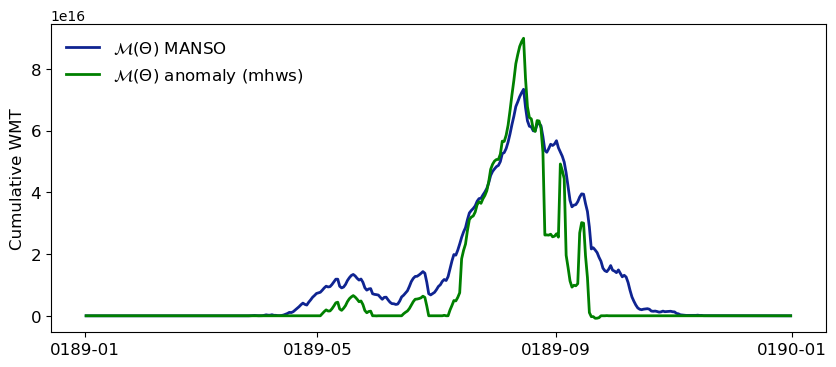

In [309]:
plt.figure(figsize=(10, 4))
year="0189"
ΔMManso = (wmt['mass_tendency']*wmt.dt).cumsum('time').sel(thetao_l_target=29, method='nearest')#.sel(time=slice('0187','0187'))
ΔMManso.sel(time=slice(f'{year}',f'{year}')).plot(label=r"$ \mathcal{M}(\Theta)$ MANSO",color='#0f2491',linewidth=2)
ΔMMHW = (budgets_sum['mass_tendency']*budgets_sum.dt).cumsum('time').sel(thetao_l_target=29, method='nearest')#.sel(time=slice('0187','0187'))
#ΔMMHW.plot(label=r"$ \mathcal{M}(\Theta)$ MHWs",color='#ed0e0e',linewidth=2)
ΔMMHW_anomaly = (budgets_sum.mass_tendency_anomaly*budgets_sum.dt).sel(thetao_l_target=29, method='nearest')#.sel(time=slice('0187','0187'))
ΔMMHW_anomaly.sel(time=slice(f'{year}',f'{year}')).plot(label=r"$ \mathcal{M}(\Theta)$ anomaly (mhws)",color='g',linewidth=2)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel(r"Cumulative WMT",fontsize=12)
plt.xlabel("")
plt.title("")

plt.legend(loc=2,frameon=False,fontsize=12)#,bbox_to_anchor=(1,-0.09))
#plt.savefig(f'/pub/mariant3/WarmWaterMasses/figures/mass_budget/dmdt-only-budget-manso-anomaly-year-{year}-talk.png', dpi=300, bbox_inches='tight')

plt.show()